In [169]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from datetime import datetime
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from scipy.stats import ttest_rel

In [2]:
def balanced_weighted_average(sentiment_scores, decay_factor):
    """
    Calculate a balanced weighted average of sentiment scores without biasing towards negative values.
    
    Parameters:
    - sentiment_scores: A list or pandas Series of sentiment scores (positive and negative).
    - decay_factor: A value between 0 and 1 to control the decay rate of weights; defaults to 0.95.
    
    Returns:
    - A single balanced weighted average score.
    """
    # Initialize positive and negative scores with respective weights
    positive_scores = sentiment_scores[sentiment_scores > 0]
    negative_scores = sentiment_scores[sentiment_scores < 0]
    
    # Calculate decay weights for each score in reverse order (older scores get smaller weights)
    decay_weights = decay_factor ** np.arange(len(sentiment_scores))[::-1]

    # Separate weights for positive and negative scores
    pos_weights = decay_weights[:len(positive_scores)]
    neg_weights = decay_weights[:len(negative_scores)]

    # Calculate the weighted average for positive and negative scores separately
    pos_weighted_avg = (positive_scores * pos_weights).sum() / pos_weights.sum() if len(pos_weights) > 0 else 0
    neg_weighted_avg = (negative_scores * neg_weights).sum() / neg_weights.sum() if len(neg_weights) > 0 else 0

    # Return the balanced average by combining positive and negative averages equally
    balanced_avg = (pos_weighted_avg + neg_weighted_avg) / 2

    return balanced_avg

In [18]:
def compute_stock_sentiment_changes(stock_symbols, interval_days, decay_factor, start_date, end_date, include_news_sentiment):
    # Initialize dictionaries to hold data
    df_stock_news_sentiment_scores_dict = {}
    df_news_sentiment_scores_dict = {}
    df_stock_data_dict = {}
    results = {}

    # Ensure start_date and end_date are datetime.date objects
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, '%Y-%m-%d').date()

    for symbol in stock_symbols:
        # Load data and convert date columns to datetime.date
        try:
            df_stock_news_sentiment_scores_dict[symbol] = pd.read_csv(f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/Sentiment_scores/stock_news_sentiment_scores/stock_news_sentiment_analysis_results_{symbol}.csv')
            if include_news_sentiment:
                df_news_sentiment_scores_dict[symbol] = pd.read_csv(f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/Sentiment_scores/news_sentiment_scores/2000-2024/sentiment_analysis_results_{symbol}.csv')
            df_stock_data_dict[symbol] = pd.read_csv(f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/stocks data/stock_data_{symbol}.csv')
        except FileNotFoundError as e:
            print(f"Error loading data for {symbol}: {e}")
            continue

        # Rename columns to distinguish sentiment sources
        if include_news_sentiment:
            df_news_sentiment_scores_dict[symbol] = df_news_sentiment_scores_dict[symbol].rename(columns={'weighted compound sentiment score': 'weighted compound news sentiment score'})
        df_stock_news_sentiment_scores_dict[symbol] = df_stock_news_sentiment_scores_dict[symbol].rename(columns={'weighted compound sentiment score': 'weighted compound stock sentiment score'})

        # Convert 'Date' to datetime.date format
        dataframes = [df_stock_news_sentiment_scores_dict[symbol], df_stock_data_dict[symbol]]
        if include_news_sentiment:
            dataframes.append(df_news_sentiment_scores_dict[symbol])

        for df in dataframes:
            df['Date'] = pd.to_datetime(df['Date']).dt.date

        # Filter data within date range
        filtered_stock_sentiment = df_stock_news_sentiment_scores_dict[symbol][
            (df_stock_news_sentiment_scores_dict[symbol]['Date'] >= start_date) & 
            (df_stock_news_sentiment_scores_dict[symbol]['Date'] <= end_date)
        ]
        if include_news_sentiment:
            filtered_news_sentiment = df_news_sentiment_scores_dict[symbol][
                (df_news_sentiment_scores_dict[symbol]['Date'] >= start_date) & 
                (df_news_sentiment_scores_dict[symbol]['Date'] <= end_date)
            ]
        filtered_stock = df_stock_data_dict[symbol][
            (df_stock_data_dict[symbol]['Date'] >= start_date) & 
            (df_stock_data_dict[symbol]['Date'] <= end_date)
        ]

        # Merge data on 'Date' using an outer join to preserve all stock dates
        merged_data = pd.merge(filtered_stock, filtered_stock_sentiment, on='Date', how='left')
        if include_news_sentiment:
            merged_data = pd.merge(merged_data, filtered_news_sentiment, on='Date', how='left')
        merged_data.sort_values(by='Date', inplace=True)

        # Fill missing sentiment scores with 0
        merged_data['weighted compound stock sentiment score'] = merged_data['weighted compound stock sentiment score'].fillna(0)

        if include_news_sentiment:
            merged_data['weighted compound news sentiment score'] = merged_data['weighted compound news sentiment score'].fillna(0)

        # Drop rows where both stock and news sentiment scores are 0
        if include_news_sentiment:
            merged_data = merged_data[
                (merged_data['weighted compound stock sentiment score'] != 0) | 
                (merged_data['weighted compound news sentiment score'] != 0)
            ]
        else:
            merged_data = merged_data[
                merged_data['weighted compound stock sentiment score'] != 0
            ]

        # Check if data is sufficient
        if len(merged_data) < interval_days:
            print(f"Not enough data for {symbol} with interval_days = {interval_days}. Skipping.")
            continue

        # Initialize lists to store results
        price_diff_list = []
        balanced_avg_stock_sentiment_list = []
        balanced_avg_news_sentiment_list = [] if include_news_sentiment else None
        sma_list = []
        sma_diff_list = []
        date_list = []

        # Calculate metrics
        for i in range(len(merged_data) - interval_days + 1):
            date_d = merged_data['Date'].iloc[i + interval_days - 1]

            # Calculate price difference
            close_d = merged_data['Close'].iloc[i]
            close_d_T = merged_data['Close'].iloc[i + interval_days - 1]
            price_diff = close_d_T - close_d

            # Calculate SMA
            sma = merged_data['Close'].iloc[i:i + interval_days].mean()

            # Calculate balanced weighted averages for sentiments
            stock_sentiment_scores = merged_data['weighted compound stock sentiment score'].iloc[i:i + interval_days]
            balanced_avg_stock_sentiment = balanced_weighted_average(stock_sentiment_scores, decay_factor)

            if include_news_sentiment:
                news_sentiment_scores = merged_data['weighted compound news sentiment score'].iloc[i:i + interval_days]
                balanced_avg_news_sentiment = balanced_weighted_average(news_sentiment_scores, decay_factor)

            # Calculate SMA difference (classification)
            if len(sma_list) > 0:  # Ensure there is a previous SMA value to compare
                prev_sma = sma_list[-1]
                sma_diff = 0 if prev_sma > sma else 1
            else:
                sma_diff = np.nan  # For the first interval, there is no previous SMA to compare

            # Append results
            date_list.append(date_d)
            price_diff_list.append(price_diff)
            sma_list.append(sma)
            sma_diff_list.append(sma_diff)
            balanced_avg_stock_sentiment_list.append(balanced_avg_stock_sentiment)
            if include_news_sentiment:
                balanced_avg_news_sentiment_list.append(balanced_avg_news_sentiment)

        # Store results for the symbol
        results[symbol] = pd.DataFrame({
            'Date': date_list,
            f'{symbol}_Price_Diff_{interval_days}d': price_diff_list,
            f'{symbol}_SMA_{interval_days}d': sma_list,
            f'{symbol}_SMA_Diff_{interval_days}d': sma_diff_list,
            f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d': balanced_avg_stock_sentiment_list
        })

        if include_news_sentiment:
            results[symbol][f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d'] = balanced_avg_news_sentiment_list

    return results


In [246]:
stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']
interval_days = 14
decay_factor = 0.95
results = compute_stock_sentiment_changes(stock_symbols, interval_days, decay_factor, start_date='2011-05-16', end_date='2024-09-21', include_news_sentiment = True)

In [165]:
def fit_sentiments_vs_metric_as_mlr(stock_symbols, results, interval_days, metric):
    """
    Fits multilinear regression of sentiment scores against either SMA or price difference.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - metric: Specify either 'sma' or 'price_diff' to choose which metric to plot.

    Returns:
    - Dictionary containing models and MSEs for each stock symbol.
    """
    # Initialize dictionaries to store linear models and MSEs
    mlr_model = {}
    mlr_mses = {}

    for symbol in stock_symbols:
        # Construct column names based on the actual interval_days and selected metric
        news_sentiment_col = f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d'
        stock_sentiment_col = f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d'
        if metric == 'sma':
            metric_col = f'{symbol}_SMA_{interval_days}d'
        elif metric == 'price_diff':
            metric_col = f'{symbol}_Price_Diff_{interval_days}d'
        else:
            print(f"Unknown metric '{metric}'. Choose 'sma' or 'price_diff'. Skipping.")
            continue

        # Check if the expected columns exist in the DataFrame for the current symbol
        if (
            symbol in results and 
            news_sentiment_col in results[symbol].columns and 
            stock_sentiment_col in results[symbol].columns and 
            metric_col in results[symbol].columns
        ):
            # Extract features (sentiment columns) and target (metric column)
            X = results[symbol][[news_sentiment_col, stock_sentiment_col]].values
            y = results[symbol][metric_col].values

            # Fit a multilinear regression model
            pipeline = Pipeline([
                ('scale', StandardScaler()),
                ('mlr', LinearRegression())
            ])
            pipeline.fit(X, y)
            y_pred = pipeline.predict(X)

            # Store the model and MSE
            mlr_model[symbol] = pipeline
            mlr_mses[symbol] = mse(y, y_pred)

            print(f"{symbol}: Model fitted. MSE = {mlr_mses[symbol]:.4f}")
        else:
            print(f"Required columns for {symbol} with interval {interval_days} days not found. Skipping.")

    return {'models': mlr_model, 'mse': mlr_mses}

In [166]:
fit_sentiments_vs_metric_as_mlr(stock_symbols, results, interval_days, 'sma')

GOOG: Model fitted. MSE = 2153.8535
MSFT: Model fitted. MSE = 17786.5724
NVDA: Model fitted. MSE = 821.8371
AMZN: Model fitted. MSE = 3590.3968
AAPL: Model fitted. MSE = 4147.8975


{'models': {'GOOG': Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
  'MSFT': Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
  'NVDA': Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
  'AMZN': Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
  'AAPL': Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())])},
 'mse': {'GOOG': np.float64(2153.853485635522),
  'MSFT': np.float64(17786.57241296954),
  'NVDA': np.float64(821.8370697658127),
  'AMZN': np.float64(3590.3967853746813),
  'AAPL': np.float64(4147.897455999962)}}

In [167]:
def run_multilinear_regression(results, stock_symbol, interval_days, metric):
    """
    Runs a multilinear regression of balanced average news and stock sentiment scores
    against either SMA or price difference.

    Parameters:
    - results: Dictionary with stock data DataFrames.
    - stock_symbol: The symbol of the stock to analyze.
    - interval_days: The interval of days over which metrics are calculated.
    - metric: Specify either 'sma' or 'price_diff' to choose which metric to analyze.
    """
    # Define column names based on interval_days and selected metric
    balanced_avg_news_sentiment_col = f'{stock_symbol}_Balanced_Avg_News_Sentiment_{interval_days}d'
    balanced_avg_stock_sentiment_col = f'{stock_symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d'
    if metric == 'sma':
        metric_col = f'{stock_symbol}_SMA_{interval_days}d'
    elif metric == 'price_diff':
        metric_col = f'{stock_symbol}_Price_Diff_{interval_days}d'
    else:
        print(f"Unknown metric '{metric}'. Choose 'sma' or 'price_diff'.")
        return

    # Check if the required columns exist in the DataFrame
    if stock_symbol in results and \
       balanced_avg_news_sentiment_col in results[stock_symbol].columns and \
       balanced_avg_stock_sentiment_col in results[stock_symbol].columns and \
       metric_col in results[stock_symbol].columns:
        
        # Extract predictor variables and the dependent variable
        X_news = np.array(results[stock_symbol][balanced_avg_news_sentiment_col])
        X_stock = np.array(results[stock_symbol][balanced_avg_stock_sentiment_col])
        y_stats = np.array(results[stock_symbol][metric_col])
        
        # Combine predictors into a single 2D array
        X_combined = np.column_stack((X_news, X_stock))
        
        # Add a constant to the predictors for the intercept
        X_with_const = sm.add_constant(X_combined)

        # Fit the OLS model
        model_ols = sm.OLS(y_stats, X_with_const)
        results_ols = model_ols.fit()

        # Print the summary to see coefficients and other statistics
        print(results_ols.summary())

        # Get the confidence intervals for the coefficients
        confidence_intervals = results_ols.conf_int(alpha=0.05)  # 95% CI by default
        print("Confidence intervals:\n", confidence_intervals)
    else:
        print(f"Required columns for {stock_symbol} with interval {interval_days} days and metric '{metric}' not found in results.")


In [168]:
# Define the parameters
stock_symbol = 'AAPL'
metric = 'sma'  

# Run the multilinear regression
run_multilinear_regression(results, stock_symbol, interval_days, metric)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     13.52
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           1.50e-06
Time:                        01:20:55   Log-Likelihood:                -9414.8
No. Observations:                1686   AIC:                         1.884e+04
Df Residuals:                    1683   BIC:                         1.885e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.6999      1.845     60.552      0.0

In [258]:
def fit_sentiments_vs_metric_as_log_reg(stock_symbols, results, interval_days, include_news_sentiment, n_splits=5):
    """
    Fits logistic regression and calculates metrics with an option to include/exclude news sentiment scores.
    Runs Kfold cross validation tests.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - include_news_sentiment: Boolean indicating whether to include news sentiment scores as features.
    - n_splits: The number Kfold cross validations tests 

    Returns:
    - Dictionary containing models and confusion matrices for each stock symbol.
    """
    # Initialize dictionaries to store models and metrics
    models = {}
    df_metrics = {}
    fold_metrics = {}

    for symbol in stock_symbols:
        # Construct column names
        stock_sentiment_col = f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d'
        news_sentiment_col = f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d'
        metric_col = f'{symbol}_SMA_Diff_{interval_days}d'

        # Check if required columns exist
        if symbol in results and stock_sentiment_col in results[symbol].columns and metric_col in results[symbol].columns:
            if include_news_sentiment and news_sentiment_col in results[symbol].columns:
                # Include both stock and news sentiment as features
                data = results[symbol][[news_sentiment_col, stock_sentiment_col, metric_col]].dropna()
                X = data[[news_sentiment_col, stock_sentiment_col]].values
            else:
                # Include only stock sentiment as features
                data = results[symbol][[stock_sentiment_col, metric_col]].dropna()
                X = data[[stock_sentiment_col]].values

            y = data[metric_col].values

            # Initialize K-Fold cross-validation
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            fold_metrics[symbol] = {
                "accuracy": [],
                "specificity": [],
                "recall": [],
                "precision": [],
                "NPV": [],
                "f1_score": [],
                "roc_auc": []
            }
            fold_models = []

            # Perform K-Fold cross-validation
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
            # Fit logistic regression
            log_reg_model = Pipeline([
                ('scale', StandardScaler()),
                ('log_reg', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000))
            ])
            log_reg_model.fit(X_train, y_train)
            y_pred = log_reg_model.predict(X_test)
            y_proba = log_reg_model.predict_proba(X_test)[:, 1]

            # Compute confusion matrix
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            # Calculate metrics
            acc = accuracy_score(y_test, y_pred)
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            rec = tp/(tp+fn) if (tp+fn) > 0 else 0 
            prec = tp/(tp+fp) if (tp+fp) > 0 else 0
            prec = tp/(tp+fp) if (tp+fp) > 0 else 0   
            npv = tn/(tn+fn) if (tn+fn) > 0 else 0

            f1 = f1_score(y_test, y_pred)  
            roc_auc = roc_auc_score(y_test, y_proba)

            # Append metrics
            fold_metrics[symbol]["accuracy"].append(acc)
            fold_metrics[symbol]["specificity"].append(spec)
            fold_metrics[symbol]["recall"].append(rec)
            fold_metrics[symbol]["precision"].append(prec)
            fold_metrics[symbol]["NPV"].append(npv)
            fold_metrics[symbol]["f1_score"].append(f1)
            fold_metrics[symbol]["roc_auc"].append(roc_auc)

            # Save the model for this fold
            fold_models.append(log_reg_model)

            # Store average metrics across folds
            df_metrics[symbol] = {
                "accuracy": np.mean(fold_metrics[symbol]["accuracy"]),
                "specificity": np.mean(fold_metrics[symbol]["specificity"]),
                "recall": np.mean(fold_metrics[symbol]["recall"]),
                "precision": np.mean(fold_metrics[symbol]["precision"]),
                "NPV": np.mean(fold_metrics[symbol]["NPV"]),
                "f1_score": np.mean(fold_metrics[symbol]["f1_score"]),
                "roc_auc": np.mean(fold_metrics[symbol]["roc_auc"])
            }

            # Save all models for this symbol
            models[symbol] = fold_models

    # Convert metrics to a DataFrame
    df_metrics = pd.DataFrame(df_metrics)
    df_metrics.reset_index(inplace=True)
    df_metrics = df_metrics.rename(columns={"index": "Metrics"})

    return df_metrics, models, fold_metrics

In [260]:
fit_sentiments_vs_metric_as_log_reg(stock_symbols, results, interval_days, include_news_sentiment=True)

(       Metrics      GOOG      MSFT      NVDA      AMZN      AAPL
 0     accuracy  0.589812  0.636076  0.700000  0.665962  0.635015
 1  specificity  0.093960  0.000000  0.000000  0.267045  0.111111
 2       recall  0.919643  1.000000  1.000000  0.902357  0.913636
 3    precision  0.604106  0.636076  0.700000  0.675063  0.659016
 4          NPV  0.437500  0.000000  0.000000  0.618421  0.406250
 5     f1_score  0.729204  0.777563  0.823529  0.772334  0.765714
 6      roc_auc  0.555669  0.465066  0.510933  0.652682  0.639122,
 {'GOOG': [Pipeline(steps=[('scale', StandardScaler()),
                   ('log_reg', LogisticRegression(max_iter=1000, penalty=None))])],
  'MSFT': [Pipeline(steps=[('scale', StandardScaler()),
                   ('log_reg', LogisticRegression(max_iter=1000, penalty=None))])],
  'NVDA': [Pipeline(steps=[('scale', StandardScaler()),
                   ('log_reg', LogisticRegression(max_iter=1000, penalty=None))])],
  'AMZN': [Pipeline(steps=[('scale', StandardScaler

In [257]:
def fit_sentiments_vs_metric_as_xgb_kfold(stock_symbols, results, interval_days, include_news_sentiment, n_splits=5):
    """
    Performs K-Fold cross-validation for XGBoost classifiers and calculates metrics.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - include_news_sentiment: Boolean indicating whether to include news sentiment scores as features.
    - n_splits: Number of splits for K-Fold cross-validation.

    Returns:
    - DataFrame containing average metrics for each stock symbol across folds.
    - Dictionary containing trained models for each stock symbol.
    """
    # Initialize dictionaries to store models and metrics
    models = {}
    df_metrics = {}
    fold_metrics = {}

    for symbol in stock_symbols:
        # Construct column names
        stock_sentiment_col = f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d'
        news_sentiment_col = f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d'
        metric_col = f'{symbol}_SMA_Diff_{interval_days}d'

        # Check if required columns exist
        if symbol in results and stock_sentiment_col in results[symbol].columns and metric_col in results[symbol].columns:
            # Build features and target
            if include_news_sentiment and news_sentiment_col in results[symbol].columns:
                data = results[symbol][[news_sentiment_col, stock_sentiment_col, metric_col]].dropna()
                X = data[[news_sentiment_col, stock_sentiment_col]].values
            else:
                data = results[symbol][[stock_sentiment_col, metric_col]].dropna()
                X = data[[stock_sentiment_col]].values

            y = data[metric_col].values

            # Handle cases where y has fewer positive or negative samples
            if len(set(y)) < 2:
                print(f"Insufficient class variation for {symbol}. Skipping.")
                continue

            # Initialize K-Fold cross-validation
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            fold_metrics[symbol] = {
                "accuracy": [],
                "specificity": [],
                "recall": [],
                "precision": [],
                "NPV": [],
                "f1_score": [],
                "roc_auc": []
            }
            fold_models = []

            # Perform K-Fold cross-validation
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Compute scale_pos_weight for class imbalance
                scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]) if len(y_train[y_train == 1]) > 0 else 1

                # Train XGBoost model
                xgb_model = Pipeline([
                ('scale', StandardScaler()),
                ('xgb_reg', xgb.XGBClassifier(
                    scale_pos_weight=scale_pos_weight,
                    eval_metric="logloss"  # Specify evaluation metric
                ))
            ]) 
                xgb_model.fit(X_train, y_train)
                y_pred = xgb_model.predict(X_test)
                y_proba = xgb_model.predict_proba(X_test)[:, 1]

                # Compute confusion matrix
                tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

                # Calculate metrics
                acc = accuracy_score(y_test, y_pred)
                spec = tn / (tn + fp) if (tn + fp) > 0 else 0
                rec = tp/(tp+fn) if (tp+fn) > 0 else 0 
                prec = tp/(tp+fp) if (tp+fp) > 0 else 0
                prec = tp/(tp+fp) if (tp+fp) > 0 else 0   
                npv = tn/(tn+fn) if (tn+fn) > 0 else 0

                f1 = f1_score(y_test, y_pred)  
                roc_auc = roc_auc_score(y_test, y_proba)

                # Append metrics
                fold_metrics[symbol]["accuracy"].append(acc)
                fold_metrics[symbol]["specificity"].append(spec)
                fold_metrics[symbol]["recall"].append(rec)
                fold_metrics[symbol]["precision"].append(prec)
                fold_metrics[symbol]["NPV"].append(npv)
                fold_metrics[symbol]["f1_score"].append(f1)
                fold_metrics[symbol]["roc_auc"].append(roc_auc)

                # Save the model for this fold
                fold_models.append(xgb_model)

            # Store average metrics across folds
            df_metrics[symbol] = {
                "accuracy": np.mean(fold_metrics[symbol]["accuracy"]),
                "specificity": np.mean(fold_metrics[symbol]["specificity"]),
                "recall": np.mean(fold_metrics[symbol]["recall"]),
                "precision": np.mean(fold_metrics[symbol]["precision"]),
                "NPV": np.mean(fold_metrics[symbol]["NPV"]),
                "f1_score": np.mean(fold_metrics[symbol]["f1_score"]),
                "roc_auc": np.mean(fold_metrics[symbol]["roc_auc"])
            }

            # Save all models for this symbol
            models[symbol] = fold_models

    # Convert metrics to a DataFrame
    df_metrics = pd.DataFrame(df_metrics)
    df_metrics.reset_index(inplace=True)
    df_metrics = df_metrics.rename(columns={"index": "Metrics"})

    return df_metrics, models, fold_metrics

In [252]:
XGB_model_without_news = fit_sentiments_vs_metric_as_xgb_kfold(stock_symbols, results, interval_days, include_news_sentiment=False)
XGB_model_with_news = fit_sentiments_vs_metric_as_xgb_kfold(stock_symbols, results, interval_days, include_news_sentiment=True)

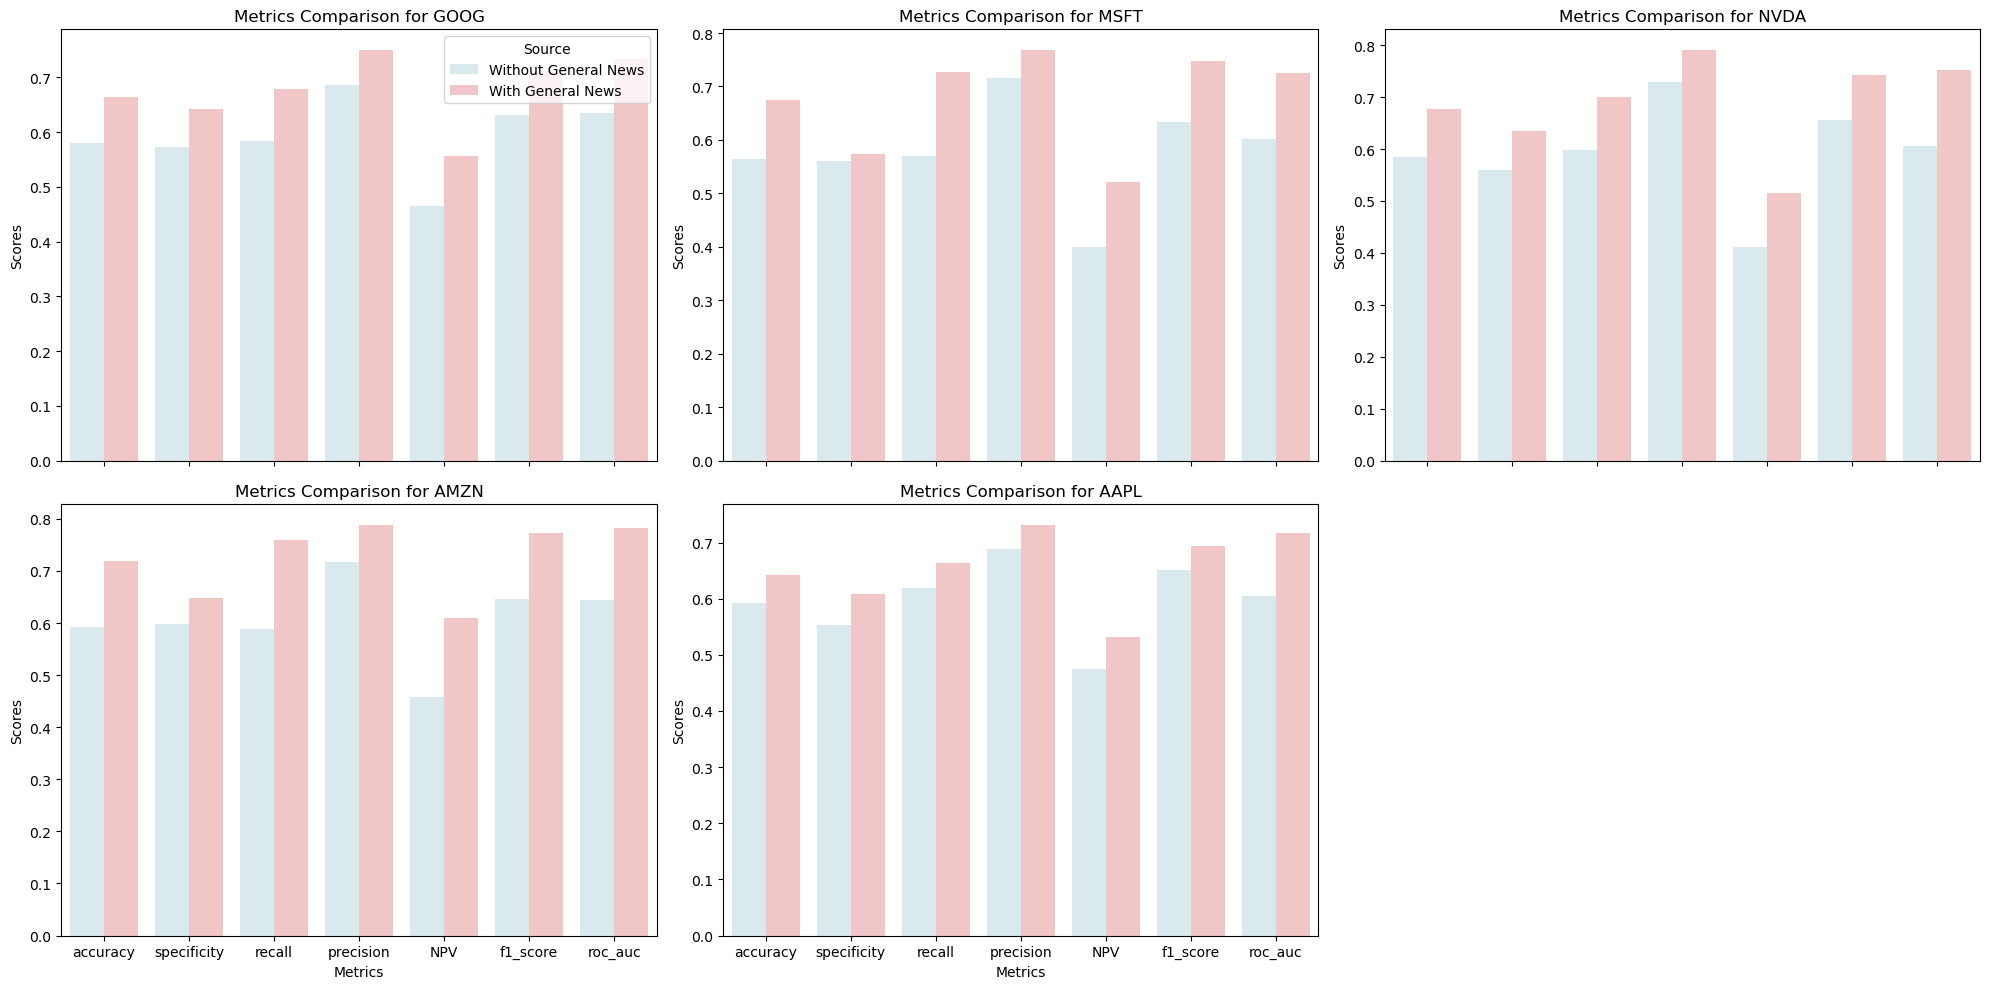

In [253]:
y_without_news = XGB_model_without_news[0]
y_with_news = XGB_model_with_news[0]

y_without_news['Source'] = 'Without General News'
y_with_news['Source'] = 'With General News'

combined_data = pd.concat([y_without_news, y_with_news])

# Calculate the number of rows and columns for subplots
n_symbols = len(stock_symbols)
n_cols = 3  # Adjust this to change the number of columns per row
n_rows = (n_symbols + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharex=True)

# Flatten axes to handle 1D indexing, and handle cases where axes are more than required
axes = axes.flatten()

for i, symbol in enumerate(stock_symbols):
    stock_data = combined_data[['Metrics', symbol, 'Source']].rename(columns={symbol: 'Score'})

    # Add a barplot to fill the boxes
    sns.barplot(
        x='Metrics', y='Score', hue='Source',
        data=stock_data,
        ax=axes[i],
        palette={'Without General News': 'lightblue', 'With General News': 'lightcoral'},
        alpha=0.5  # Add transparency to bar plot
    )
    
    # Customize each subplot
    axes[i].set_title(f'Metrics Comparison for {symbol}')
    axes[i].set_ylabel('Scores')
    axes[i].set_xlabel('Metrics')

    # Add legend only to the first subplot
    if i == 0:
        axes[i].legend(title='Source', loc='upper right')
    else:
        axes[i].get_legend().remove()

# Hide unused subplots (if any)
for j in range(len(stock_symbols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [254]:
all_metrics = XGB_model_with_news[2]['GOOG'].keys()                    
for symbol in stock_symbols:
    for metric in all_metrics:
        metric_without_news = np.array(XGB_model_without_news[2][symbol][metric])
        metric_with_news = np.array(XGB_model_with_news[2][symbol][metric])
        metric_diff = metric_with_news - metric_without_news
        # Perform paired t-test
        t_stat, p_value = ttest_rel(metric_without_news, metric_with_news)

        #print(f"T-statistic: {t_stat}, p-value: {p_value}")

        if p_value < 0.05:
            print(f"The difference in {metric} for {symbol} is statistically significant.")
        else:
            print(f"The difference in {metric} for {symbol} is not statistically significant.")

The difference in accuracy for GOOG is statistically significant.
The difference in specificity for GOOG is statistically significant.
The difference in recall for GOOG is statistically significant.
The difference in precision for GOOG is statistically significant.
The difference in NPV for GOOG is statistically significant.
The difference in f1_score for GOOG is statistically significant.
The difference in roc_auc for GOOG is statistically significant.
The difference in accuracy for MSFT is statistically significant.
The difference in specificity for MSFT is not statistically significant.
The difference in recall for MSFT is statistically significant.
The difference in precision for MSFT is statistically significant.
The difference in NPV for MSFT is statistically significant.
The difference in f1_score for MSFT is statistically significant.
The difference in roc_auc for MSFT is statistically significant.
The difference in accuracy for NVDA is statistically significant.
The difference

In [255]:
decay_factors = [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.95, 1.00]
stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']
interval_days = 14
precision_scores = {key: [] for key in stock_symbols}
recall_scores = {key: [] for key in stock_symbols}
specificity_scores = {key: [] for key in stock_symbols}
npv_scores = {key: [] for key in stock_symbols}

start_date='2011-05-16'
end_date='2024-09-21'

for decay_factor in decay_factors:
    results = compute_stock_sentiment_changes(stock_symbols, interval_days, decay_factor, start_date, end_date, include_news_sentiment = True)
    XGB_model_with_news = fit_sentiments_vs_metric_as_xgb_kfold(stock_symbols, results, interval_days, include_news_sentiment=True)
   
    for symbol in stock_symbols:     
        precision_score = XGB_model_with_news[0][symbol][3]
        recall_score = XGB_model_with_news[0][symbol][2]
        specificity_score = XGB_model_with_news[0][symbol][1]
        npv_score = XGB_model_with_news[0][symbol][4]

        precision_scores[symbol].append(precision_score)
        recall_scores[symbol].append(recall_score)
        specificity_scores[symbol].append(specificity_score)
        npv_scores[symbol].append(npv_score)

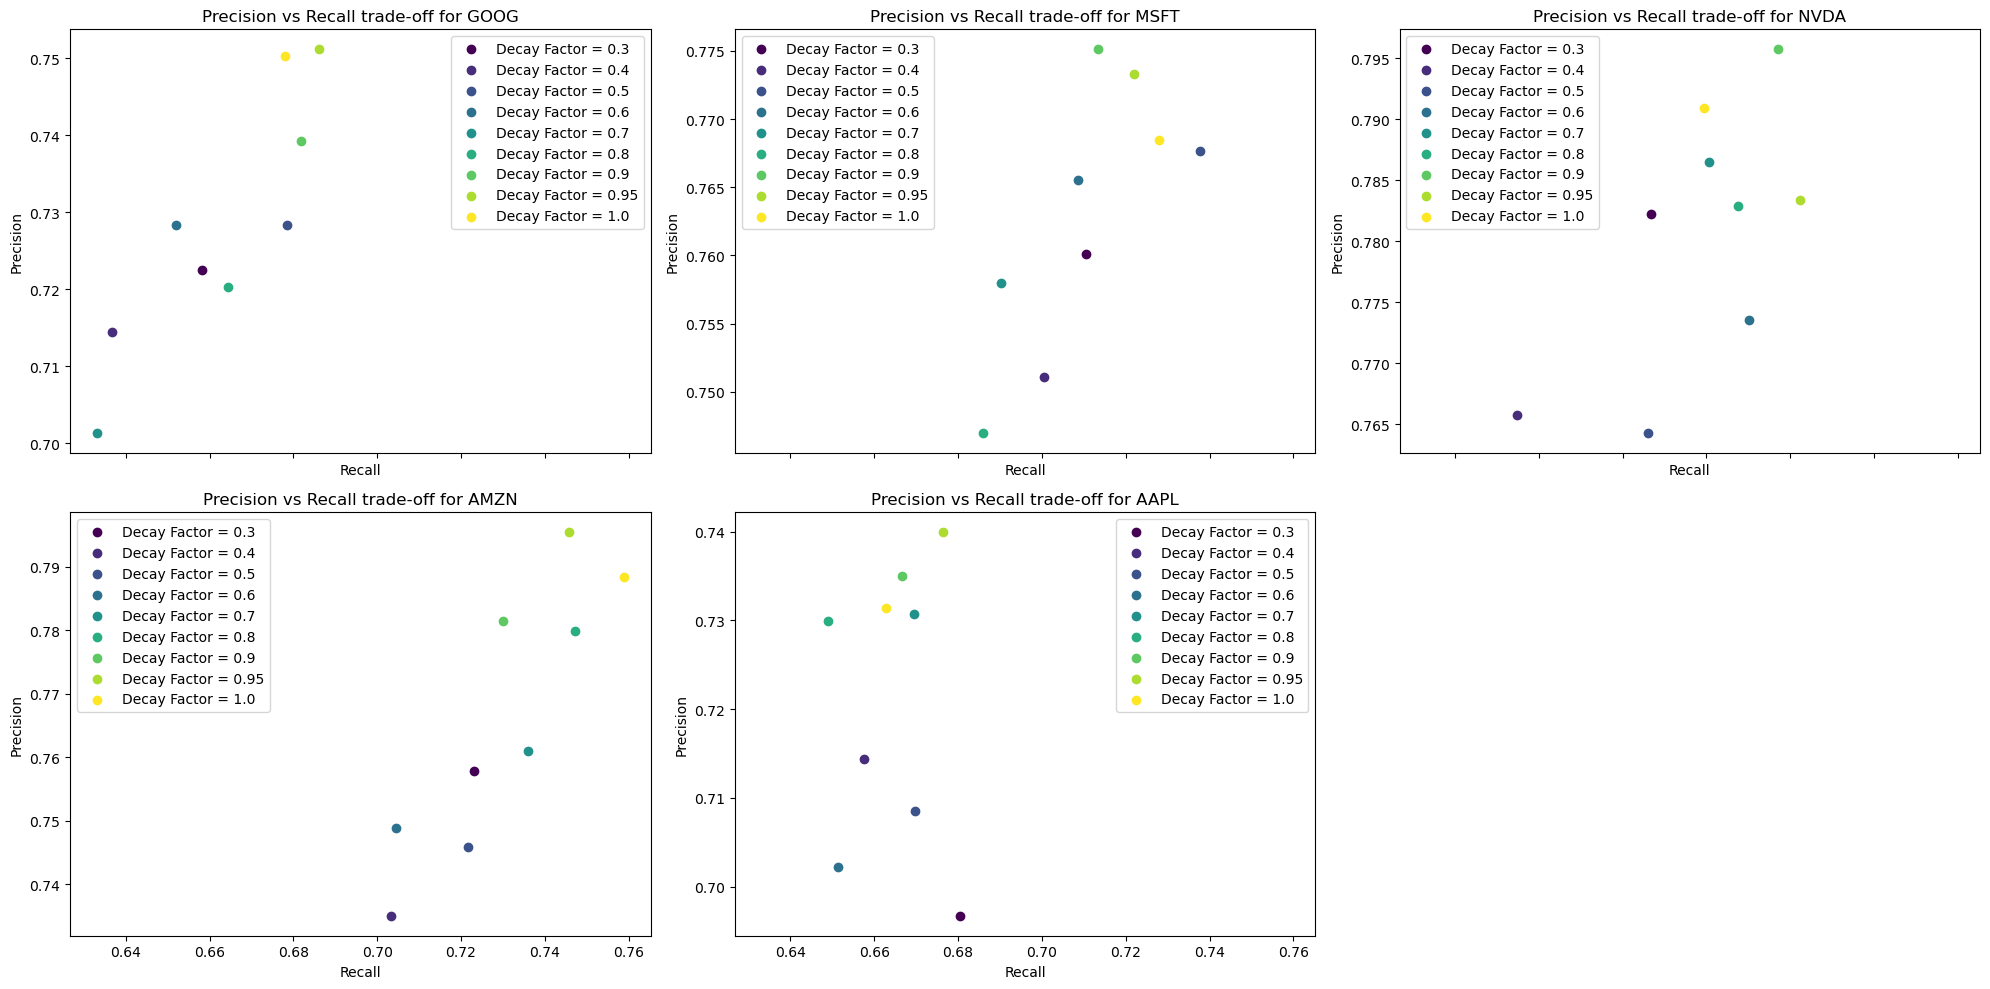

In [256]:
# Calculate the number of rows and columns for subplots
n_symbols = len(stock_symbols)
n_cols = 3  # Adjust this to change the number of columns per row
n_rows = (n_symbols + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharex=True)

# Flatten axes to handle 1D indexing, and handle cases where axes are more than required
axes = axes.flatten()

# Define a color map
colors = cm.viridis(np.linspace(0, 1, len(decay_factors)))

for i, symbol in enumerate(stock_symbols):
    axes[i].set_title(f'Precision vs Recall trade-off for {symbol}')
    
    # Plot each decay factor with a unique color
    for j, decay_factor in enumerate(decay_factors):
        axes[i].scatter(
            recall_scores[symbol][j], 
            precision_scores[symbol][j], 
            label=f'Decay Factor = {decay_factor}', 
            color=colors[j]
        )
    
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].legend(loc='best')

# Hide unused subplots (if any)
for j in range(len(stock_symbols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

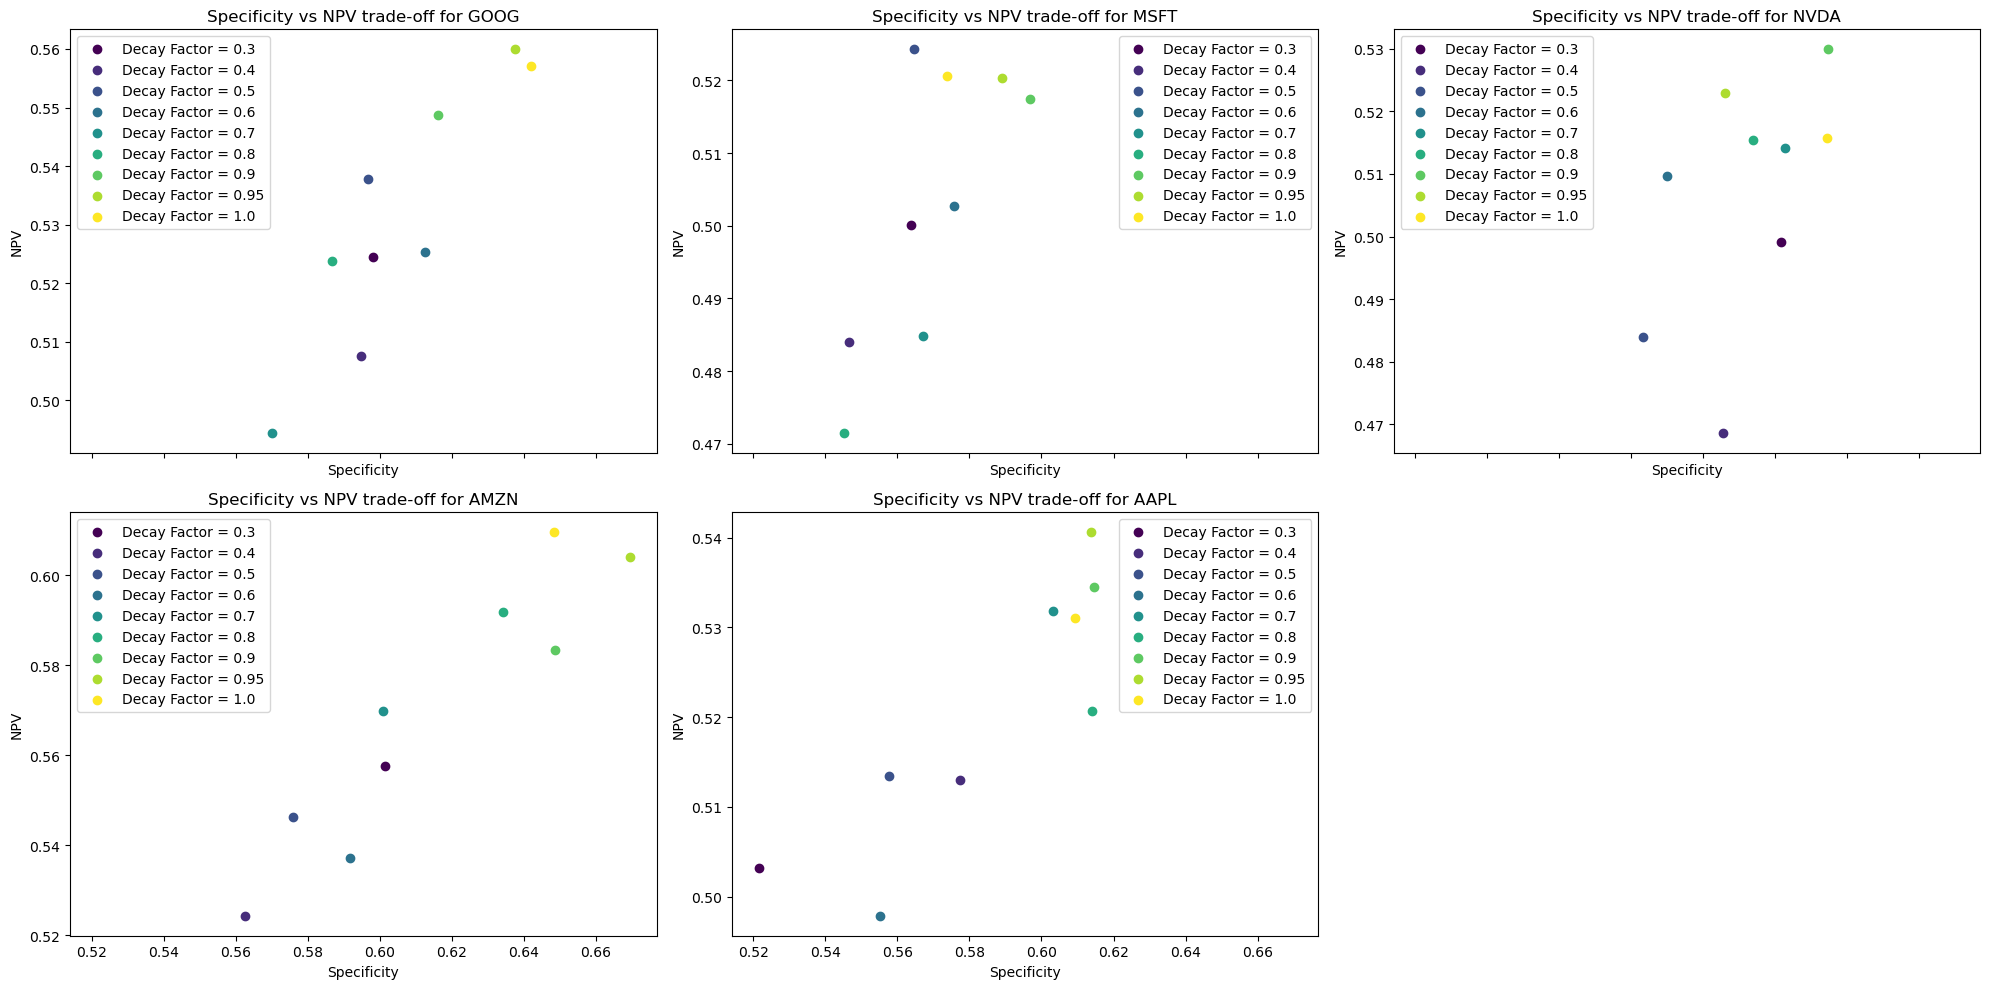

In [261]:
# Calculate the number of rows and columns for subplots
n_symbols = len(stock_symbols)
n_cols = 3  # Adjust this to change the number of columns per row
n_rows = (n_symbols + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharex=True)

# Flatten axes to handle 1D indexing, and handle cases where axes are more than required
axes = axes.flatten()

# Define a color map
colors = cm.viridis(np.linspace(0, 1, len(decay_factors)))

for i, symbol in enumerate(stock_symbols):
    axes[i].set_title(f'Specificity vs NPV trade-off for {symbol}')
    
    # Plot each decay factor with a unique color
    for j, decay_factor in enumerate(decay_factors):
        axes[i].scatter(
            specificity_scores[symbol][j], 
            npv_scores[symbol][j], 
            label=f'Decay Factor = {decay_factor}', 
            color=colors[j]
        )
    
    axes[i].set_xlabel('Specificity')
    axes[i].set_ylabel('NPV')
    axes[i].legend(loc='best')

# Hide unused subplots (if any)
for j in range(len(stock_symbols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()